<a href="https://colab.research.google.com/github/kkipngenokoech/DA-course/blob/main/Mapping_RH_and_Wind_Speeds_in_West_Africa_(SOLVED).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mapping RH and Wind Speeds in West Africa

Using downloaded MERRA-2 data to investigate conditions on the ground

In [1]:
%%capture
!pip install cartopy

In [2]:
# Import all relevant packages

import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import glob
import re
from datetime import timedelta, datetime, date
from matplotlib import pyplot as plt
import cartopy.feature as cfeature
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy

#import hvplot
#from netCDF4 import Dataset
#from windrose import WindroseAxes

# Phase 1: Load in the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Open up MERRA-2 Environmental Data

MER_ENV_DIR = '/content/drive/MyDrive/DA Lecture 9 Env Data/Environmental'
string_glob = str(MER_ENV_DIR) + '/*.nc'

mer_data = xr.open_mfdataset(string_glob)
mer_data

<xarray.Dataset> Size: 410MB
Dimensions:   (time: 1096, lat: 156, lon: 120)
Coordinates:
  * time      (time) datetime64[ns] 9kB 2019-01-01 2019-01-02 ... 2021-12-31
  * lat       (lat) float64 1kB -36.0 -35.5 -35.0 -34.5 ... 40.0 40.5 41.0 41.5
  * lon       (lon) float64 960B -21.25 -20.62 -20.0 -19.38 ... 51.88 52.5 53.12
Data variables:
    QLML      (time, lat, lon) float32 82MB dask.array<chunksize=(1, 156, 120), meta=np.ndarray>
    RHOA      (time, lat, lon) float32 82MB dask.array<chunksize=(1, 156, 120), meta=np.ndarray>
    SPEED     (time, lat, lon) float32 82MB dask.array<chunksize=(1, 156, 120), meta=np.ndarray>
    SPEEDMAX  (time, lat, lon) float32 82MB dask.array<chunksize=(1, 156, 120), meta=np.ndarray>
    TLML      (time, lat, lon) float32 82MB dask.array<chunksize=(1, 156, 120), meta=np.ndarray>

In [5]:
# Open up additional wind data

MER_WIN_DIR = '/content/drive/MyDrive/DA Lecture 9 Env Data/Wind'
string_glob = str(MER_WIN_DIR) + '/*.nc'

wind_data = xr.open_mfdataset(string_glob)
wind_data

<xarray.Dataset> Size: 337MB
Dimensions:  (time: 1096, lat: 149, lon: 129)
Coordinates:
  * time     (time) datetime64[ns] 9kB 2019-01-01 2019-01-02 ... 2021-12-31
  * lat      (lat) float64 1kB -37.5 -37.0 -36.5 -36.0 ... 35.0 35.5 36.0 36.5
  * lon      (lon) float64 1kB -23.75 -23.12 -22.5 -21.88 ... 55.0 55.62 56.25
Data variables:
    QV2M     (time, lat, lon) float32 84MB dask.array<chunksize=(1, 149, 129), meta=np.ndarray>
    T2M      (time, lat, lon) float32 84MB dask.array<chunksize=(1, 149, 129), meta=np.ndarray>
    U2M      (time, lat, lon) float32 84MB dask.array<chunksize=(1, 149, 129), meta=np.ndarray>
    V2M      (time, lat, lon) float32 84MB dask.array<chunksize=(1, 149, 129), meta=np.ndarray>

# Phase 2: Apply a function and Merge data

In [6]:
def wind_uv_to_dir(U, V):
    """
    Convert u and v wind components to meteorological wind direction.

    Meteorological convention reports where wind is coming FROM:
      - 0°/360° = from the North
      - 90°  = from the East
      - 180° = from the South
      - 270° = from the West

    Parameters:
        U: east-west wind component (positive = from west)
        V: north-south wind component (positive = from south)

    Returns:
        Wind direction in degrees (0-360)
    """
    # Step 1: Get the angle using math convention
    #         0° = East, angles increase counterclockwise
    math_angle = np.rad2deg(np.arctan2(V, U))

    # Step 2: Convert to compass bearing
    #         Compass: 0° = North, angles increase clockwise
    compass_bearing = (90 - math_angle) % 360

    # Step 3: Flip to meteorological convention
    #         Compass bearing points where wind is going TO
    #         Meteorology reports where wind is coming FROM
    #         So rotate 180° to get the opposite direction
    wind_direction = (compass_bearing + 180) % 360

    return wind_direction

In [7]:
# Add in wind speed and direction to the dataset

#ws = np.sqrt(U2M_nans**2+V2M_nans**2)
#wind_data = wind_data.assign(ws=lambda x: np.sqrt(x.U2M**2+x.V2M**2))

# Calculate wind speed from U and V components
wind_data['ws'] = np.sqrt(wind_data['U2M']**2 + wind_data['V2M']**2)

# Calculate wind direction from U and V components
wind_data['ws_direction'] = wind_uv_to_dir(wind_data['U2M'], wind_data['V2M'])


wind_data

<xarray.Dataset> Size: 506MB
Dimensions:       (time: 1096, lat: 149, lon: 129)
Coordinates:
  * time          (time) datetime64[ns] 9kB 2019-01-01 2019-01-02 ... 2021-12-31
  * lat           (lat) float64 1kB -37.5 -37.0 -36.5 -36.0 ... 35.5 36.0 36.5
  * lon           (lon) float64 1kB -23.75 -23.12 -22.5 ... 55.0 55.62 56.25
Data variables:
    QV2M          (time, lat, lon) float32 84MB dask.array<chunksize=(1, 149, 129), meta=np.ndarray>
    T2M           (time, lat, lon) float32 84MB dask.array<chunksize=(1, 149, 129), meta=np.ndarray>
    U2M           (time, lat, lon) float32 84MB dask.array<chunksize=(1, 149, 129), meta=np.ndarray>
    V2M           (time, lat, lon) float32 84MB dask.array<chunksize=(1, 149, 129), meta=np.ndarray>
    ws            (time, lat, lon) float32 84MB dask.array<chunksize=(1, 149, 129), meta=np.ndarray>
    ws_direction  (time, lat, lon) float32 84MB dask.array<chunksize=(1, 149, 129), meta=np.ndarray>

In [8]:
# Try merging the wind data
#save_folder = '/content/drive/MyDrive/Colab Notebooks/Lecture 9 - xarray practice/Data'
merged_wind = xr.merge([mer_data, wind_data], compat='override', join='inner')

print(f"Variables in merged dataset: {list(merged_wind.data_vars)}")
print(f"Time range: {merged_wind.time.values[0]} to {merged_wind.time.values[-1]}")
merged_wind

Variables in merged dataset: ['QLML', 'RHOA', 'SPEED', 'SPEEDMAX', 'TLML', 'QV2M', 'T2M', 'U2M', 'V2M', 'ws', 'ws_direction']
Time range: 2019-01-01T00:00:00.000000000 to 2021-12-31T00:00:00.000000000


<xarray.Dataset> Size: 845MB
Dimensions:       (time: 1096, lon: 120, lat: 146)
Coordinates:
  * time          (time) datetime64[ns] 9kB 2019-01-01 2019-01-02 ... 2021-12-31
  * lon           (lon) float64 960B -21.25 -20.62 -20.0 ... 51.88 52.5 53.12
  * lat           (lat) float64 1kB -36.0 -35.5 -35.0 -34.5 ... 35.5 36.0 36.5
Data variables:
    QLML          (time, lat, lon) float32 77MB dask.array<chunksize=(1, 146, 120), meta=np.ndarray>
    RHOA          (time, lat, lon) float32 77MB dask.array<chunksize=(1, 146, 120), meta=np.ndarray>
    SPEED         (time, lat, lon) float32 77MB dask.array<chunksize=(1, 146, 120), meta=np.ndarray>
    SPEEDMAX      (time, lat, lon) float32 77MB dask.array<chunksize=(1, 146, 120), meta=np.ndarray>
    TLML          (time, lat, lon) float32 77MB dask.array<chunksize=(1, 146, 120), meta=np.ndarray>
    QV2M          (time, lat, lon) float32 77MB dask.array<chunksize=(1, 146, 120), meta=np.ndarray>
    T2M           (time, lat, lon) float32 77MB dask.array<chunksize=(1, 146, 120), meta=np.ndarray>
    U2M           (time, lat, lon) float32 77MB dask.array<chunksize=(1, 146, 120), meta=np.ndarray>
    V2M           (time, lat, lon) float32 77MB dask.array<chunksize=(1, 146, 120), meta=np.ndarray>
    ws            (time, lat, lon) float32 77MB dask.array<chunksize=(1, 146, 120), meta=np.ndarray>
    ws_direction  (time, lat, lon) float32 77MB dask.array<chunksize=(1, 146, 120), meta=np.ndarray>

In [ ]:
#

In [9]:
# AERONET site coordinates: {name: [lat, lon]}
city_locs = {
    "Ouagadougou": [12.42413, -1.48723],
    "Banizoumbou": [13.54693, 2.66519],
    "Niamey": [13.481389, 2.172222],
    "Koforidua": [6.109408, -0.302058],
    "Koforidua_ANUC": [6.109408, -0.302058],
    "Ilorin": [8.484100, 4.674500],
    "Djougou": [9.76007, 1.59901],
    "Accra": [5.6037, -0.1870],
    "Abidjan": [5.3600, 4.000],
    "Tamale": [9.4034, -0.8424],
    "Koupela": [12.1802, -0.3513],
    "Bamako": [12.6306, -8.0191],
    "AddisAbabaSchool": [9.0590, 38.7636],
    "Conakry": [9.5958, -13.6369],
    "NDjamena": [12.1022, 15.0478],
    "KhartoumEmbassy": [15.5272, 32.6085],
    "Algiers": [36.7566, 3.0392],
    "IER_Cinzana": [13.2784, -5.9339],
    "LAMTO-STATION": [6.2235, -5.0266],
}


def get_city_data(city, data, city_locs=city_locs, latlon=None):
    """Extract time series at the nearest grid point to a city or coordinate."""
    if latlon is not None:
        lat, lon = latlon
    else:
        lat, lon = city_locs[city]

    # xarray's built-in nearest-neighbor selection
    return data.sel(lat=lat, lon=lon, method="nearest")


def plot_time_series(city, var, data, city_locs=city_locs):
    """Plot a single variable's time series for a given city."""
    city_data = get_city_data(city, data, city_locs)
    city_data[var].plot()
    plt.title(f"{var} at {city}")
    #plt.show()



In [10]:
# Extract data for a city
niamey = get_city_data("Niamey", merged_wind)

# Use custom coordinates instead of a city name - random point
custom_point = get_city_data(None, merged_wind, latlon=(10.5, 1.2))

niamey

<xarray.Dataset> Size: 57kB
Dimensions:       (time: 1096)
Coordinates:
  * time          (time) datetime64[ns] 9kB 2019-01-01 2019-01-02 ... 2021-12-31
    lon           float64 8B 1.875
    lat           float64 8B 13.5
Data variables:
    QLML          (time) float32 4kB dask.array<chunksize=(1,), meta=np.ndarray>
    RHOA          (time) float32 4kB dask.array<chunksize=(1,), meta=np.ndarray>
    SPEED         (time) float32 4kB dask.array<chunksize=(1,), meta=np.ndarray>
    SPEEDMAX      (time) float32 4kB dask.array<chunksize=(1,), meta=np.ndarray>
    TLML          (time) float32 4kB dask.array<chunksize=(1,), meta=np.ndarray>
    QV2M          (time) float32 4kB dask.array<chunksize=(1,), meta=np.ndarray>
    T2M           (time) float32 4kB dask.array<chunksize=(1,), meta=np.ndarray>
    U2M           (time) float32 4kB dask.array<chunksize=(1,), meta=np.ndarray>
    V2M           (time) float32 4kB dask.array<chunksize=(1,), meta=np.ndarray>
    ws            (time) float32 4kB dask.array<chunksize=(1,), meta=np.ndarray>
    ws_direction  (time) float32 4kB dask.array<chunksize=(1,), meta=np.ndarray>

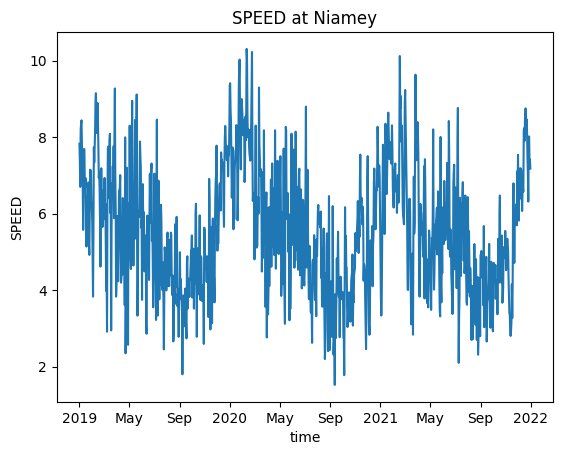

In [11]:
# Plot wind speed at Niamey
plot_time_series("Niamey", "SPEED", merged_wind)

Text(0.5, 0, '')

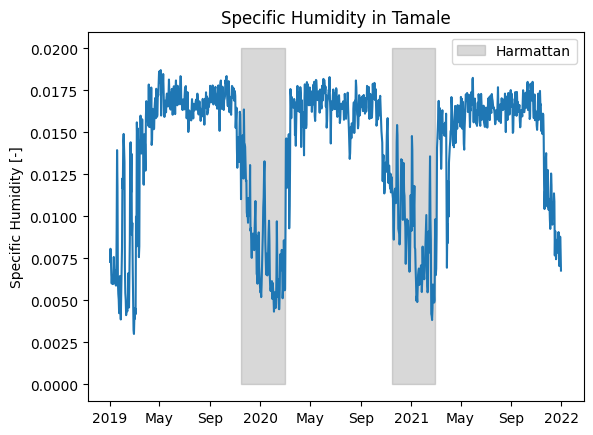

In [13]:
city = 'Tamale'
plot_time_series(city,'QLML',merged_wind)

# Add shading to indicate Harmattan season
plt.fill_between(['2019-11-15','2020-03-01'],0.02,y2=0,color='gray',alpha=.3,label='Harmattan')
plt.fill_between(['2020-11-15','2021-03-01'],0.02,y2=0,color='gray',alpha=.3)
plt.legend()


title = f'Specific Humidity in {city}'
plt.title(title)
plt.ylabel('Specific Humidity [-]')
plt.xlabel('')

Text(0.5, 0, '')

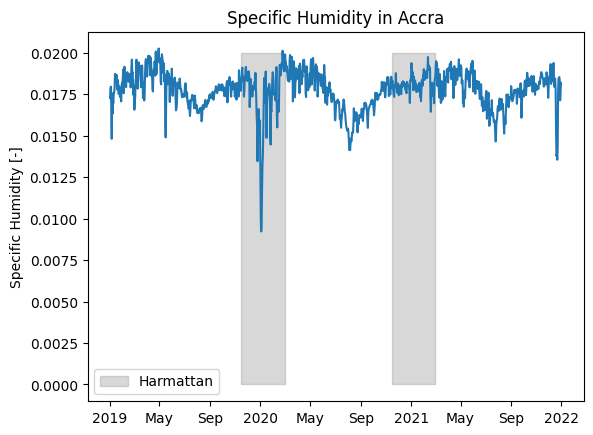

In [14]:
# Visualize the data - Average Wind Speeds in Accra
city = 'Accra'
plot_time_series(city,'QLML',merged_wind)

# Add shading to indicate Harmattan season
plt.fill_between(['2019-11-15','2020-03-01'],0.02,y2=0,color='gray',alpha=.3,label='Harmattan')
plt.fill_between(['2020-11-15','2021-03-01'],0.02,y2=0,color='gray',alpha=.3)
plt.legend()


title = f'Specific Humidity in {city}'
plt.title(title)
plt.ylabel('Specific Humidity [-]')
plt.xlabel('')


### Adding in some histogram analysis

In [15]:
def SplitHarmattan(data_df,harm_months=None):

    # Define and Select the proper season
    if harm_months is None:
        harm_months = [11,12,1,2,3]
        non_harm_months = [4,5,6,7,8,9,10]
    else:
        all_months = list(range(1, 13))
        # Convert lists to sets for more efficient membership testing
        set_a = set(all_months)
        set_b = set(harm_months)

        # Create a list of numbers in 'a' but not in 'b'
        non_harm_months = list(set_a - set_b)

    # Extract the month from the 'Date' column and create a subset
    harm = data_df[data_df['time'].dt.month.isin(harm_months)]
    nonharm = data_df[data_df['time'].dt.month.isin(non_harm_months)]

    return harm,nonharm

Text(0, 0.5, 'Frequency [-]')

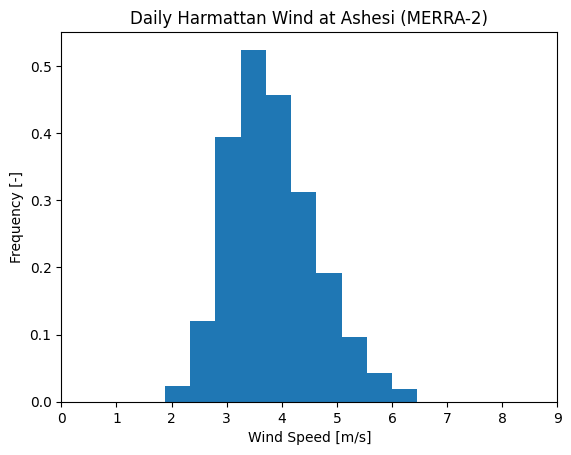

In [16]:
# Plot a histogram of windspeeds during and outside of the Harmattan
city_locs['Ashesi'] = [5.7609, -0.2197] # Add Ashesi to the analysis
city = 'Ashesi'
harm_wind,nonharm_wind = SplitHarmattan(merged_wind['SPEEDMAX']) #,harm_months=harm_months)
city_harm_wind = get_city_data(city,harm_wind)
city_nonharm_wind = get_city_data(city,nonharm_wind)

city_harm_wind.plot.hist(density=1, bins=10)
title = f'Daily Harmattan Wind at {city} (MERRA-2)'
plt.title(title)
plt.xlabel('Wind Speed [m/s]')
plt.xlim(0,9)
plt.ylabel('Frequency [-]')
#plt.savefig(f'{save_folder}/{title}.png',dpi=300)

Text(0.5, 0, 'Wind Speed [m/s]')

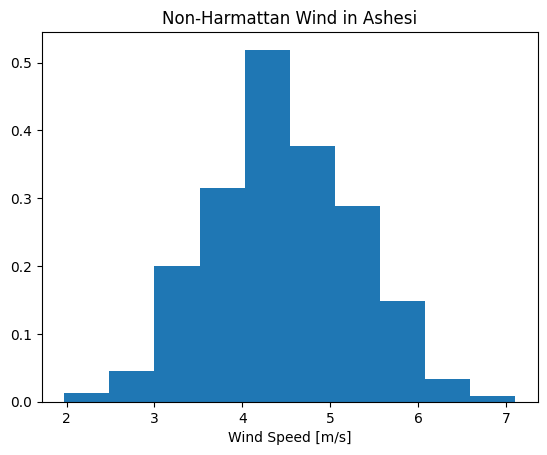

In [17]:
city_nonharm_wind.plot.hist(density=1, bins=10)
plt.title(f'Non-Harmattan Wind in {city}')
plt.xlabel('Wind Speed [m/s]')

# Phase 4: Create Average Wind Speed and Direction maps

In [18]:
def create_average_map(input_xarr, title, extent=None, levels=None,
                       save=False, label_name=None, cmap='viridis'):
    """
    Plot a spatial average map from an xarray DataArray.

    Parameters:
        input_xarr: xarray DataArray (2D, lat x lon)
        title: plot title
        extent: [west, east, south, north] bounding box (defaults to West Africa)
        levels: contour levels (defaults to 10 evenly spaced levels)
        save: if True, saves the figure as a PNG
        label_name: colorbar label
        cmap: colormap name (default 'viridis')

    Returns:
        fig, ax for further annotation
    """
    # Default extent: West Africa
    if extent is None:
        extent = [-17.16, 34.4, 3.48, 22.18]

    # Default contour levels based on the data
    if levels is None:
        levels = np.linspace(float(input_xarr.min()), float(input_xarr.max()),
                             num=10, endpoint=True)

    # Create the figure and map
    fig = plt.figure(figsize=(8, 4))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ax._autoscaleXon = False
    ax._autoscaleYon = False

    ax.set_extent(extent, ccrs.PlateCarree())
    ax.coastlines(resolution="110m", linewidth=1)
    ax.gridlines(linestyle='--', color='black')
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

    # Plot filled contours
    cont = plt.contourf(input_xarr.lon, input_xarr.lat, input_xarr,
                         levels, transform=ccrs.PlateCarree(),
                         cmap=cmap, extend='max')

    plt.title(title, size=14)

    # Colorbar
    cb = plt.colorbar(cont, ax=ax, orientation="vertical",
                       pad=0.02, aspect=16, shrink=0.8)
    cb.set_label(label_name, size=12, rotation=90, labelpad=15)
    cb.ax.tick_params(labelsize=10)

    if save:
        plt.savefig(f'{title}.png', dpi=300)

    return fig, ax

In [19]:
def SeasonalAverages(ds):

    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'.
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    ds_weighted = (ds * weights).groupby("time.season").sum(dim="time")

    return ds_weighted

In [20]:
# Create averges over the Harmattan

def HarmattanAverages(data_xr):

    # Define and Select the proper season
    harm_months = [11,12,1,2,3]
    non_harm_months = [4,5,6,7,8,9,10]

    monthly = data_xr.groupby('time.month').mean(dim='time')

    harm = monthly.sel(month=harm_months).mean(dim='month')
    nonharm = monthly.sel(month=non_harm_months).mean(dim='month')

    return harm,nonharm


In [21]:
harm,nonharm = HarmattanAverages(merged_wind)

In [22]:
nonharm['SPEED']

<xarray.DataArray 'SPEED' (lat: 146, lon: 120)> Size: 70kB
dask.array<mean_agg-aggregate, shape=(146, 120), dtype=float32, chunksize=(146, 120), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 1kB -36.0 -35.5 -35.0 -34.5 ... 35.0 35.5 36.0 36.5
  * lon      (lon) float64 960B -21.25 -20.62 -20.0 -19.38 ... 51.88 52.5 53.12

In [25]:
list(harm.data_vars)

['QLML',
 'RHOA',
 'SPEED',
 'SPEEDMAX',
 'TLML',
 'QV2M',
 'T2M',
 'U2M',
 'V2M',
 'ws',
 'ws_direction']

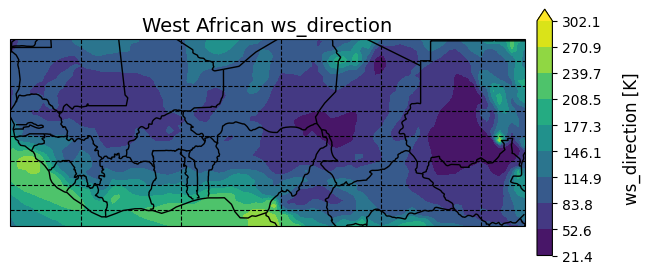

In [27]:
var = 'ws_direction'

fig, ax = create_average_map(
    harm[var],
    title=f'West African {var}',
    label_name=f'{var} [K]'
)
plt.show()

# Phase 5: Make a GIF

In [34]:
# Select the year 2020
data_2020 = merged_wind.sel(time=merged_wind.time.dt.year == 2020)

var = 'TLML'
levels = np.arange(240, 300) # <----- Adjust this to your liking

month_names = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

for month in range(1, 13):
    monthly_avg = data_2020.sel(time=data_2020.time.dt.month == month).mean(dim='time')

    # Recall there are other parameters you can pass in!
    fig, ax = create_average_map(
        monthly_avg[var],
        title=f'West African {var} - {month_names[month - 1]} 2020',
        label_name='Wind Speed [m/s]',
        levels=levels,
        cmap='viridis',
        save=False
    )

    plt.savefig(f'{var}_{month:02d}_2020.png', dpi=300, bbox_inches='tight')
    plt.close()

    print(f'Saved {month_names[month - 1]}')

Saved January
Saved February
Saved March
Saved April
Saved May
Saved June
Saved July
Saved August
Saved September
Saved October
Saved November
Saved December


In [35]:
from PIL import Image
import glob

# Load all the saved frames in order
var = 'TLML'
filenames = sorted(glob.glob(f'{var}_*_2020.png'))
frames = [Image.open(f) for f in filenames]

# Save as GIF
frames[0].save(
    f'{var}_2020.gif',
    save_all=True,
    append_images=frames[1:],
    duration=500,  # milliseconds per frame
    loop=0         # 0 = loop forever
)

print('GIF saved!')

GIF saved!


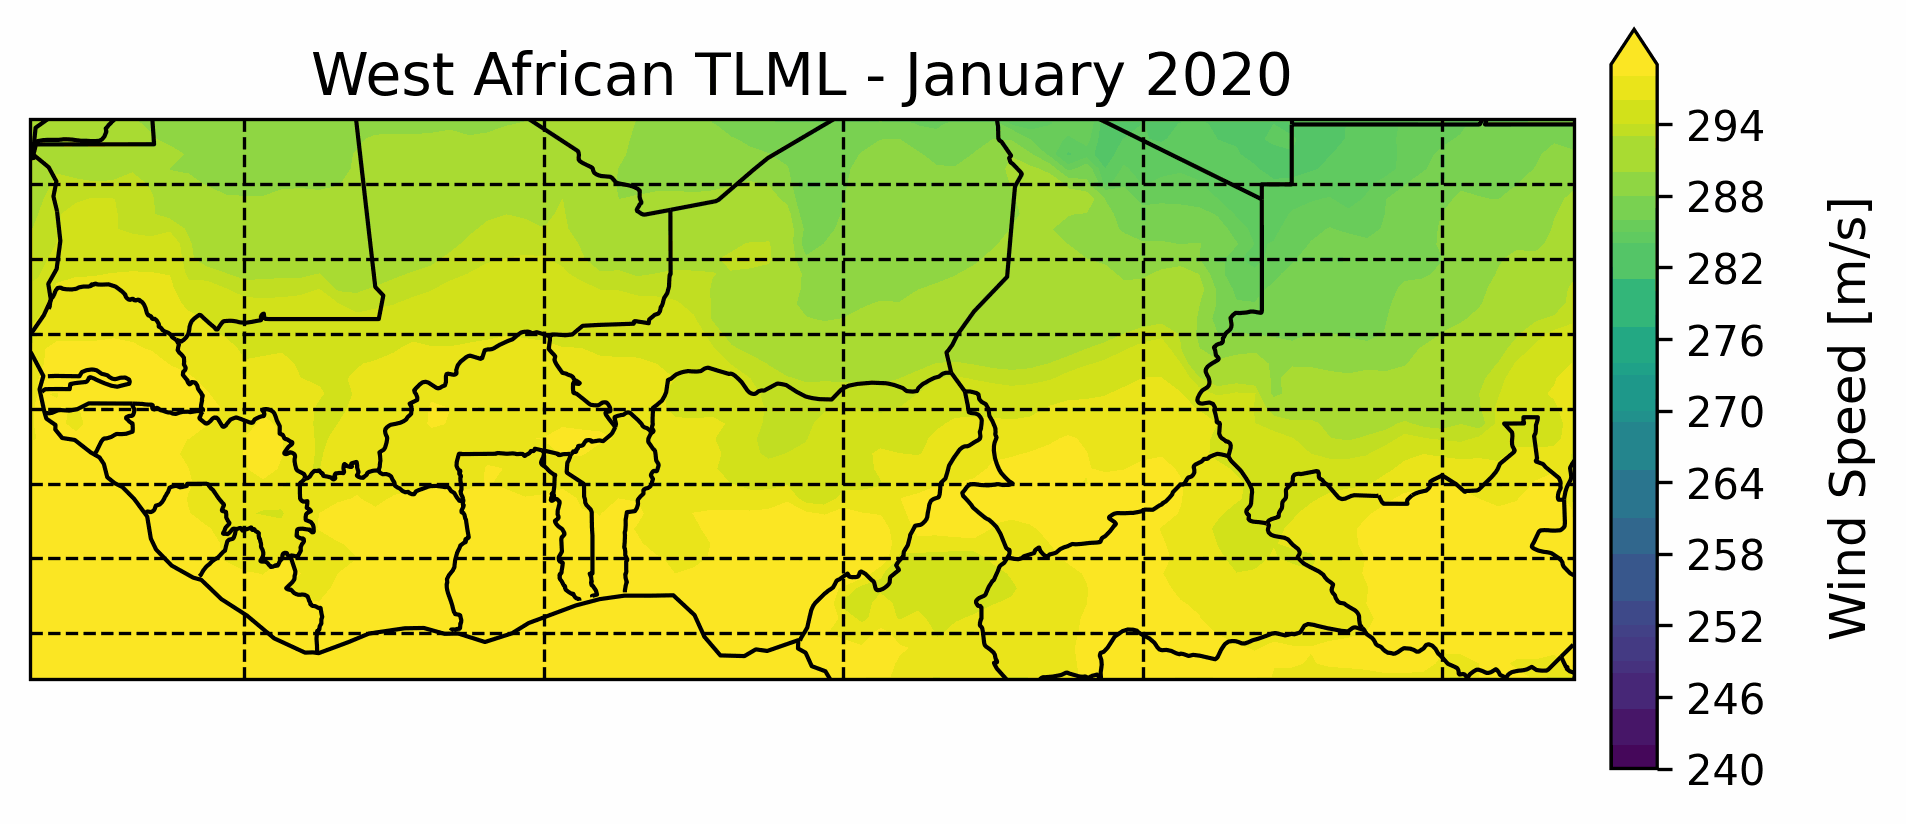

In [36]:
from IPython.display import Image, display

display(Image(filename=f'{var}_2020.gif'))

# BONUS - Make a quiver plot

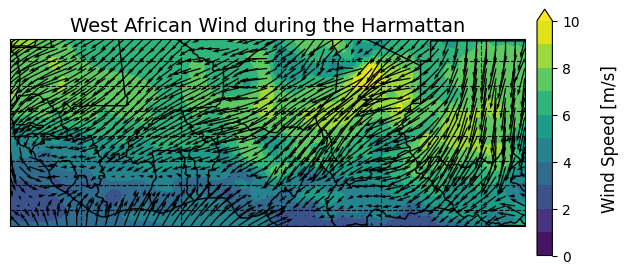

In [37]:
title = 'West African Wind during the Harmattan'

levels = np.arange(0, 11)

fig, ax = create_average_map(
    harm['SPEEDMAX'],
    title=title,
    levels=levels,
    label_name='Wind Speed [m/s]'
)

# Overlay wind vectors
plt.quiver(harm.lon, harm.lat, harm.U2M, harm.V2M,
           scale=50, color='k', transform=ccrs.PlateCarree(),
           regrid_shape=20)

In [ ]:
merged_wind_seasons = SeasonalAverages(merged_wind)